# 3.数据初探

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE#TSNE提供了一种有效的降维方式，让我们对高于2维数据的聚类结果以二维的方式展示出来
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## 3.1数据观察

In [2]:
train_data_path = 'G:/kaggle/house-prices-advanced-regression-techniques/data/train.csv'
train_data = pd.read_csv(train_data_path)    #type(train_data)>>>pandas.core.frame.DataFrame

In [3]:
train_data.shape[0]

1460

<Figure size 432x288 with 0 Axes>

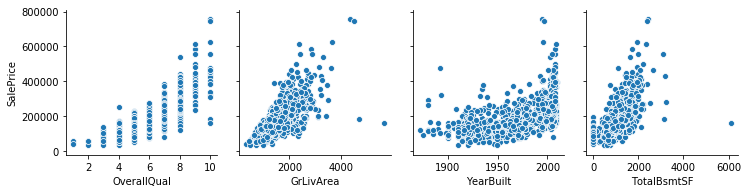

In [4]:
#数据可视化
figure = plt.figure()
sns.pairplot(x_vars = ['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],y_vars = ['SalePrice'],data = train_data,dropna = True)
plt.show()

In [5]:
#删除异常点
train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>2e5)].index,inplace = True)
train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<2e5)].index,inplace = True)
train_data.drop(train_data[(train_data['YearBuilt']>1900) & (train_data['SalePrice']>4e5)].index,inplace = True)
train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<2e5)].index,inplace = True)
train_data.reset_index(drop = True, inplace = True)#删除了几行数据之后，重新整理列索引

<Figure size 432x288 with 0 Axes>

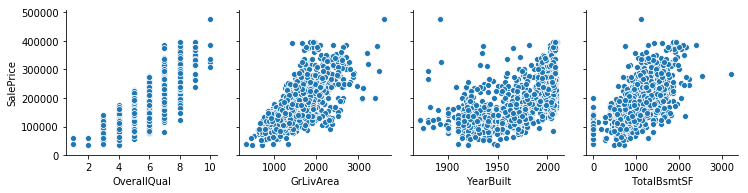

In [6]:
#再次数据可视化
figure = plt.figure()
sns.pairplot(x_vars = ['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],y_vars = ['SalePrice'],data = train_data,dropna = True)
plt.show()

## 3.2 数据合并

In [7]:
#数据合并
test_data_path = 'G:/kaggle/house-prices-advanced-regression-techniques/data/test.csv'
test_data = pd.read_csv(test_data_path)#列索引为[0-1459]
my_data = pd.concat([train_data,test_data],axis = 0,sort = False)#列索引为[0-1429,0-1459]

In [8]:
my_data.reset_index(drop=True,inplace = True)#更新列索引变为【0-2889】
train_index = train_data.index#【0-1429】为训练集数据
#print('train_index:',train_index)
test_index = list(set(my_data.index).difference(set(train_data.index)))#【1430-2889】为测试集数据
#print('test_index:',test_index)

# 4. 处理缺失值

观察各列数据缺失情况

In [9]:
#my_data = pd.concat([train_data,test_data],sort = False)
count = my_data.isnull().sum().sort_values(ascending = False)
ratio = count/len(my_data)
nulldata = pd.concat([count,ratio],axis = 1,keys = ['count','ratio'],sort = False)

In [10]:
nulldata[0:10]

,count,ratio
PoolQC,2881,0.997231
MiscFeature,2784,0.963655
Alley,2691,0.931464
Fence,2319,0.802700
SalePrice,1459,0.505019
FireplaceQu,1420,0.491520
LotFrontage,483,0.167186
GarageQual,159,0.055036
GarageYrBlt,159,0.055036
GarageFinish,159,0.055036


观察变量之间的相关性

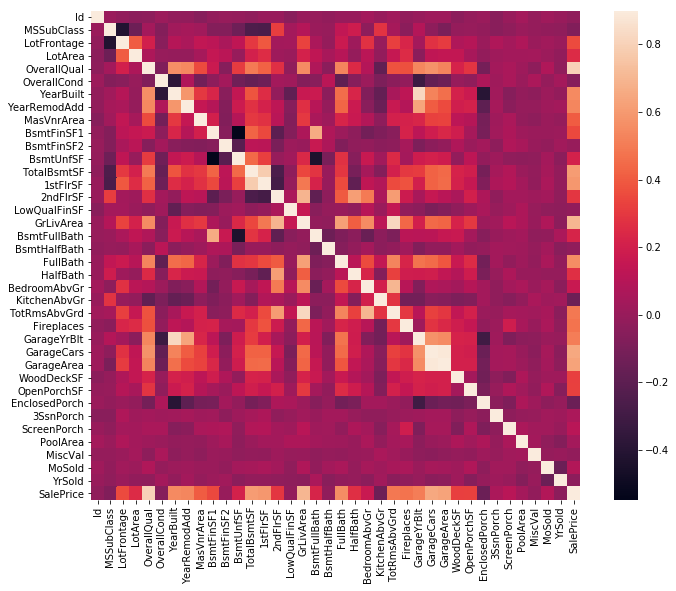

In [11]:

corrmat = train_data.corr()#变量间相关系数，默认皮尔逊系数【-1，1】
plt.subplots(figsize = (12,9))
sns.heatmap(corrmat,vmax = 0.9,square = True)#将数据绘制为颜色方格
plt.show()

## 4.1 插补缺失数据

In [12]:
#填充缺失值
def fill_missings(res):
    
    res['Alley'].fillna('missing',inplace = True)
    res['PoolQC'].fillna(res['PoolQC'].mode()[0],inplace = True)#用众数填充
    res['MasVnrType'].fillna('None',inplace = True)
    res['BsmtQual'].fillna(res['BsmtQual'].mode()[0],inplace = True)
    res['BsmtCond'].fillna(res['BsmtCond'].mode()[0],inplace = True)
    res['FireplaceQu'].fillna(res['FireplaceQu'].mode()[0],inplace = True)
    res['GarageType'].fillna('missing',inplace = True)
    res['GarageFinish'].fillna(res['GarageFinish'].mode()[0],inplace = True)
    res['GarageQual'].fillna(res['GarageQual'].mode()[0],inplace = True)
    res['GarageCond'].fillna('missing',inplace = True)
    res['Fence'].fillna('missing',inplace = True)
    res['Street'].fillna('missing',inplace = True)
    res['LotShape'].fillna('missing',inplace = True)
    res['LandContour'].fillna('missing',inplace = True)
    res['BsmtExposure'].fillna(res['BsmtExposure'].mode()[0],inplace = True)
    res['BsmtFinType1'].fillna('missing',inplace = True)
    res['BsmtFinType2'].fillna('missing',inplace = True)
    res['CentralAir'].fillna('missing',inplace = True)
    res['Electrical'].fillna(res['Electrical'].mode()[0],inplace = True)
    res['MiscFeature'].fillna('missing',inplace = True)
    res['MSZoning'].fillna(res['MSZoning'].mode()[0],inplace = True)
    res['Utilities'].fillna('missing',inplace = True)
    res['Exterior1st'].fillna(res['Exterior1st'].mode()[0],inplace = True)
    res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0],inplace = True)
    res['KitchenQual'].fillna(res['KitchenQual'].mode()[0],inplace = True)
    res['GarageYrBlt'].fillna(res['GarageYrBlt'].mode()[0],inplace = True)
    res['Functional'].fillna('Typ',inplace = True)
    res['SaleType'].fillna(res['SaleType'].mode()[0],inplace = True)
    
    #数值型变量的缺失值用0填充
    flist = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
            'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
            'TotRmsAbvGrd','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF',
            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','GarageCars']
    for fl in flist:
        res[fl].fillna(0,inplace = True)
    
    #0值替换(为什么要替换0值，而且值还很大)
#     res['TotalBsmtSF'] = res['TotalBsmtSF'].apply(lambda x:np.exp(6) if x <= 0.0)
#     res['2ndFlrSF'] = res['2ndFlrSF'].apply(lambda x:np.exp(6.5) if x <=0.0)
#     res['GarageArea'] = res['GarageArea'].apply(lambda x:np.exp(6) if x <=0.0)
#     res['GarageCars'] = res['GarageCars'].apply(lambda x:0 if x <=0.0)
#     res['LotFrontage'] = res['LotFrontage'].apply(lambda x:np.exp(4.2) if x <=0.0)
#     res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x:np.exp(4) if x <=0.0)
#     res['BsmtFinSF1'] = res['BsmtFinSF1'].apply(lambda x:np.exp(6.5) if x <=0.0)
    return res
my_data = fill_missings(my_data)

In [13]:
#检查是否还有缺失值
#al_data = pd.concat([train_data,test_data],sort = False)
count = my_data.isnull().sum().sort_values(ascending = False)
ratio = count/len(my_data)
nulldata = pd.concat([count,ratio],axis = 1,keys = ['count','ratio'],sort = False)

In [14]:
nulldata[0:10]

,count,ratio
SalePrice,1459,0.505019
Heating,0,0.000000
RoofStyle,0,0.000000
RoofMatl,0,0.000000
Exterior1st,0,0.000000
Exterior2nd,0,0.000000
MasVnrType,0,0.000000
MasVnrArea,0,0.000000
ExterQual,0,0.000000
ExterCond,0,0.000000


# 5.特征工程

In [15]:
#一些特征被表示成数值特征缺乏意义，例如年份还有类别，这里将其转换为字串，即类别型变量
my_data['MSSubClass'] = my_data['MSSubClass'].astype(str)
my_data['YrSold'] = my_data['YrSold'].astype(str)
my_data['MoSold'] = my_data['MoSold'].astype(str)
my_data['OverallCond'] = my_data['OverallCond'].astype(str)

In [16]:
print(type(my_data['MSSubClass'][0]))
print(type(my_data['YrSold'][0]))
print(type(my_data['MoSold'][0]))
print(type(my_data['OverallCond'][0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


## 5.1顺序特征编码

### 注意到在所有特征中还存在一些顺序变量(ordinal variable),不同于一般的类型变量（categorical variable），顺序变量之间存在固有的顺序 比如 (低, 中, 高) 、病人疼痛指数 ( 1 到 10 - 但是他们之间的差是没有意义的, 因为1 到 10 仅仅表现了顺序)。对于顺序变量，标签编码（LabelEncoder）的方式无法正确识别这种顺序关系。因此这里通过自定义函数实现编码转换。

In [17]:
#因为是顺序变量，变量间实际上是有高低之分的，LabelEncoder().fit([x])并不能识别x列表中元素之间的顺序，所以要先排好顺序
def EGTFP_QualToInt(x):
    if (x =='Ex'):
        r = 0
    elif (x =='Gd'):
        r = 1
    elif (x =='TA'):
        r = 2
    elif (x == 'Fa'):
        r = 3
    elif (x == 'missing'):
        r = 4
    else:
        r = 5
        
    return r

EGTFP_qualList = ['HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond',
                  'PoolQC','ExterQual','ExterCond','BsmtQual','BsmtCond']
for index in EGTFP_qualList:
    my_data[index] = my_data[index].apply(EGTFP_QualToInt)

In [18]:
my_data['HeatingQC']

0       0
1       0
2       0
3       1
4       0
       ..
2884    1
2885    2
2886    0
2887    2
2888    0
Name: HeatingQC, Length: 2889, dtype: int64

In [19]:
def BsmtFinType1_QualToInt(x):
    if (x =='GLQ'):
        r = 0
    elif (x =='ALQ'):
        r = 1
    elif (x =='BLQ'):
        r = 2
    elif (x == 'Rec'):
        r = 3
    elif (x == 'LwQ'):
        r = 4
    elif (x == 'Unf'):
        r = 5
    elif (x == 'missing'):
        r = 6
#     else:
#         r = 5
        
    return r

my_data['BsmtFinType1'] = my_data['BsmtFinType1'].apply(BsmtFinType1_QualToInt)

In [20]:
def MasVnrType_QualToInt(x):
    if (x =='BrkCmn'):
        r = 0
    elif (x =='BrkFace'):
        r = 1
    elif (x =='CBlock'):
        r = 2
    elif (x == 'Stone'):
        r = 3
    elif (x == 'None'):
        r = 4
       
    return r

my_data['MasVnrType'] = my_data['MasVnrType'].apply(MasVnrType_QualToInt)

In [21]:
def Foundation_QualToInt(x):
    if (x =='BrkTil'):
        r = 0
    elif (x =='CBlock'):
        r = 1
    elif (x =='PConc'):
        r = 2
    elif (x == 'Slab'):
        r = 3
    elif (x == 'Stone'):
        r = 4
    elif (x == 'Wood'):
        r = 5
       
    return r

my_data['Foundation'] = my_data['Foundation'].apply(Foundation_QualToInt)

In [22]:
from sklearn import preprocessing

qual_list = ['HouseStyle','Functional','BsmtExposure',
             'GarageFinish','PavedDrive','Street',
            'PavedDrive']
le = preprocessing.LabelEncoder()
for index in qual_list:
    le.fit(list(set(my_data[index])))
    my_data[index] = le.transform(my_data[index])

In [23]:
my_data['Street']

0       1
1       1
2       1
3       1
4       1
       ..
2884    1
2885    1
2886    1
2887    1
2888    1
Name: Street, Length: 2889, dtype: int32

## 5.2 增添特征


In [24]:
#由于区域相关特征对于确定房价非常重要，我们还增加了一个特征，即每个房屋的地下室，一楼和二楼的总面积。
my_data['TotalSF'] = my_data['TotalBsmtSF'] + my_data['1stFlrSF'] + my_data['2ndFlrSF']

In [25]:
'''房屋内某些区域空间的有无通常也是影响房屋价格的重要因素，例如房屋内多加一块三季门廊区(3SsnPorch)，
#房价可能就会有明显的上涨。因此这里我们再增添几个特征用于描述房屋内是否存在这些区域空间'''

my_data['HasWoodDeck'] = (my_data['WoodDeckSF'] == 0) * 1
my_data['HasOpenPorch'] = (my_data['OpenPorchSF'] == 0) * 1
my_data['HasEnclosedPorch'] = (my_data['EnclosedPorch'] == 0) * 1
my_data['Has3SsnPorch'] = (my_data['3SsnPorch'] == 0) * 1
my_data['HasScreenPorch'] = (my_data['ScreenPorch'] == 0) * 1

In [26]:
#房屋改造时间（YearsSinceRemodel）与房屋出售时间（YrSold）间隔时间的长短通常也会影响房价
my_data['YearsSinceRemodel'] = my_data['YrSold'].astype(int) - my_data['YearRemodAdd'].astype(int)

In [27]:
#房屋的整体质量也是影响房价的重要要因素
my_data['Total_Home_Quality'] = my_data['OverallQual'].astype(int) + my_data['OverallCond'].astype(int)

## 5.3数据转换

#### 数据转换的方式有很多种，比较常用的有对数转换，box-cox转换等变换方式，其中对数转换的方式是最为常用的，取对数之后数据的性质和相关关系不会发生改变，但压缩了变量的尺度，大大方便了计算。先绘制每个定量变量与目标变量的分布图

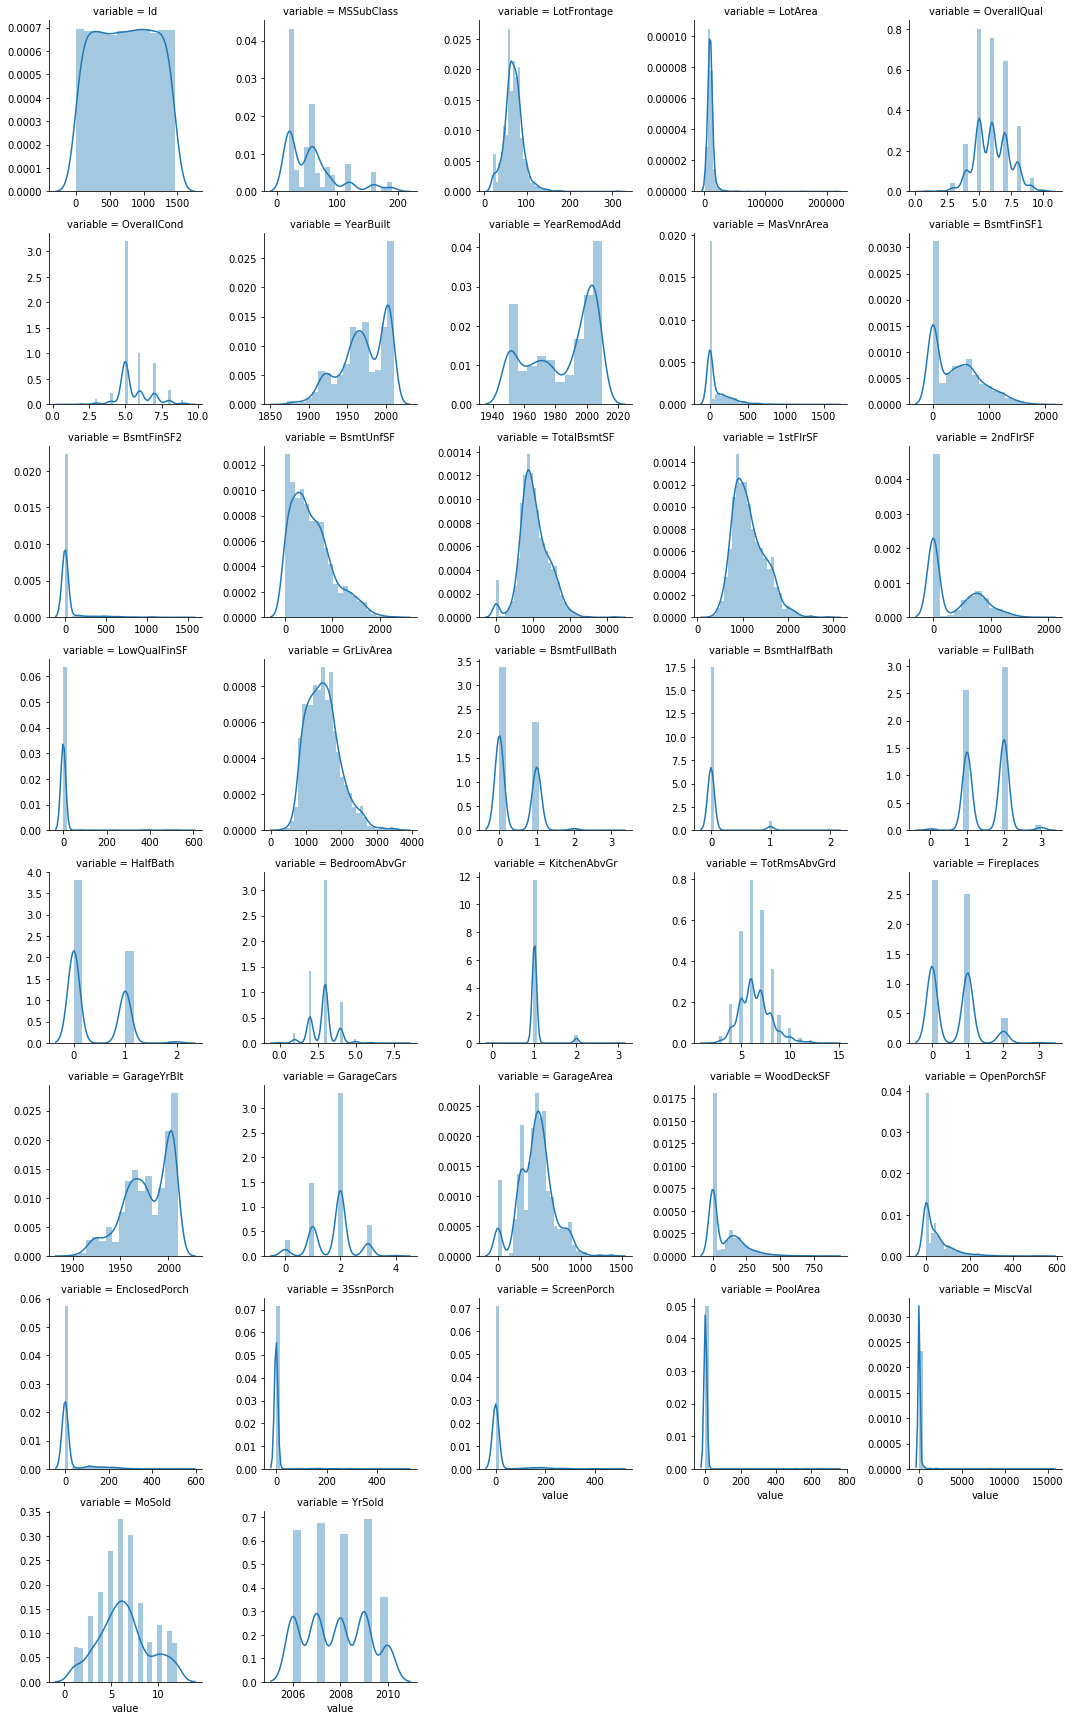

In [28]:
#查看每个变量中的某个值的数据在所有数据中的占比
quantitative = [f for f in train_data.columns if train_data.dtypes[f] != 'object' and train_data.dtypes[f] != 'str']
quantitative.remove('SalePrice')
f = pd.melt(train_data,value_vars = quantitative)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5,  palette="Set1",sharex = False, sharey = False)
g = g.map(sns.distplot,'value')#sns.distplot 直方图和核密度估计
plt.show()

#### 计算个定量变量的偏度

In [116]:
skewed_feats = my_data[quantitative].astype(int).apply(lambda x: skew(x.dropna())).sort_values(ascending = False)#my_data[quantitative]中有str类型的数据，所以要转换成int.x.dropna()没用处，因为之前已经填充过缺失值了
skewness = pd.DataFrame({'Skew':skewed_feats})
skewness.head(20)

,Skew
MiscVal,21.834083
PoolArea,18.617525
LotArea,13.649906
LowQualFinSF,12.025272
3SsnPorch,11.316146
KitchenAbvGr,4.276620
BsmtFinSF2,4.136098
EnclosedPorch,4.007952
ScreenPorch,3.969442
BsmtHalfBath,3.921999


#### 结合图的描述，可以看到个定量变量都有不同程度的偏移，对于偏度大于0.15的定量变量，我们可以对其进行log操作以提升质量。

In [117]:
def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01+ res[l].astype(float))).values)#部分数据dtypes=='object'，要转换成float或int
        res.columns.values[m] = l + '_log'
        m += 1
    return res
loglist = skewness[abs(skewness > 0.15)].index.tolist()
my_data = addlogs(my_data, loglist)

In [159]:
#########################
al_data = my_data[:]
#a = al_data.dtypes['MiscVal']

In [80]:
####################################################
loglist = skewness[abs(skewness > 0.15)].index.tolist()

al_data['2ndFlrSF']
for index in loglist:
   # print(al_data.dtypes[index])
    if al_data.dtypes[index] == 'object':
        print(2)
        print(index)


2
MSSubClass
2
OverallCond
2
MoSold
2
YrSold


In [160]:
#########################################
def addlogs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.DataFrame(np.log(1.01+ res[l].astype(float))).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res
loglist = skewness[abs(skewness) > 0.15].index.tolist()
al_data = addlogs(al_data, loglist)

In [161]:
al_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold_log,OverallQual_log,FullBath_log,YrSold_log,Id_log,LotFrontage_log,GarageCars_log,YearRemodAdd_log,GarageYrBlt_log,YearBuilt_log
0,1,60,RL,65.0,8450,1,missing,Reg,Lvl,AllPub,...,1.101940,2.080691,1.101940,7.605397,0.698135,4.189806,1.101940,7.602905,7.602905,7.602905
1,2,20,RL,80.0,9600,1,missing,Reg,Lvl,AllPub,...,1.793425,1.947338,1.101940,7.604899,1.101940,4.394573,1.101940,7.589341,7.589341,7.589341
2,3,60,RL,68.0,11250,1,missing,IR1,Lvl,AllPub,...,2.303585,2.080691,1.101940,7.605397,1.388791,4.234251,1.101940,7.602406,7.601907,7.601907
3,4,70,RL,60.0,9550,1,missing,IR1,Lvl,AllPub,...,1.101940,2.080691,0.698135,7.604401,1.611436,4.111038,1.388791,7.586301,7.600407,7.558000
4,5,60,RL,84.0,14260,1,missing,IR1,Lvl,AllPub,...,2.565718,2.198335,1.101940,7.605397,1.793425,4.442769,1.388791,7.601407,7.601407,7.601407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,2915,160,RM,21.0,1936,1,missing,Reg,Lvl,AllPub,...,1.947338,1.611436,0.698135,7.604401,7.977972,3.091497,0.009950,7.586301,7.603903,7.586301
2885,2916,160,RM,21.0,1894,1,missing,Reg,Lvl,AllPub,...,1.611436,1.611436,0.698135,7.604401,7.978314,3.091497,0.698135,7.586301,7.586301,7.586301
2886,2917,20,RL,160.0,20000,1,missing,Reg,Lvl,AllPub,...,2.303585,1.793425,0.698135,7.604401,7.978657,5.081466,1.101940,7.599406,7.581215,7.581215
2887,2918,85,RL,62.0,10441,1,missing,Reg,Lvl,AllPub,...,2.080691,1.793425,0.698135,7.604401,7.979000,4.143293,0.009950,7.597401,7.603903,7.597401


## 5.4独热编码

#### 找出所有需要编码的定性变量，这里记得要除去已经做了转换的顺序变量。

In [118]:
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object' or train_data.dtypes[f] == 'str']
oridinals = ['HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond',
             'PoolQC','ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HouseStyle','Functional','BsmtExposure','GarageFinish','PavedDrive',
             'Street', 'PavedDrive','BsmtFinType1','MasVnrType','Foundation'
            ]
qualitative = list(set(qualitative).difference(set(oridinals)))

#### 对定性编码进行独热编码，并与之前的顺序变量以及已经做了log转换的定量变量合并为一个数据集

In [119]:
def getdummies(res, ls):
    def encode(encode_df):
        encode_df = np.array(encode_df)
        enc = preprocessing.OneHotEncoder(sparse = False,categories='auto' )#如果不加 sparse = False 的话，输出的是稀疏的存储格式，即索引加值的形式
        le = preprocessing.LabelEncoder()
        le.fit(encode_df)
        res1 = le.transform(encode_df).reshape(-1,1) #type(res1) == numpy.ndarray
        enc.fit(res1)
        return pd.DataFrame(enc.transform(res1)),le,enc#
    decoder = []
    outres = pd.DataFrame({'A':[]})
    
    for l in ls:
        cat,le,enc = encode(res[l])
        cat.columns = [l+str(x) for x in cat.columns]
        outres.reset_index(drop = True, inplace = True)
        outres = pd.concat([outres, cat],axis = 1, sort = False)
        decoder.append([le, enc])
    return (outres,decoder)

catpredlist = qualitative
res = getdummies(my_data[catpredlist],catpredlist)
df = res[0]
decoder = res[1]
floatAndordinal = list(set(my_data.columns.values).difference(set(qualitative)))
df = pd.concat([df, my_data[floatAndordinal]], axis = 1)
df.drop(['A','SalePrice'],axis = 1,inplace = True)#删除'A'列

In [120]:
df

,SaleType0,SaleType1,SaleType2,SaleType3,SaleType4,SaleType5,SaleType6,SaleType7,SaleType8,Alley0,...,BsmtFinSF1_log,LotFrontage,OpenPorchSF_log,TotalBsmtSF_log,ExterQual,GarageArea_log,2ndFlrSF,GarageYrBlt_log,Has3SsnPorch,KitchenAbvGr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.561045,65.0,4.127296,6.753450,1,6.308117,854,7.602905,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.886542,80.0,0.009950,7.141253,2,6.133420,0,7.589341,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.188285,68.0,3.761433,6.825471,1,6.411835,866,7.601907,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.379943,60.0,3.583797,6.629376,2,6.466160,756,7.600407,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.486176,84.0,4.442769,7.044042,1,6.729836,1053,7.601407,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.009950,21.0,0.009950,6.304467,2,0.009950,546,7.603903,1,1
2885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.533429,21.0,3.219276,6.304467,2,5.659517,546,7.586301,1,1
2886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.110704,160.0,0.009950,7.110704,2,6.357860,0,7.581215,1,1
2887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.823075,62.0,3.496811,6.816747,2,0.009950,0,7.603903,1,1


## 5.5特征降维

#### PCA降维

In [121]:
pca = PCA(n_components = 200)
df  = pd.DataFrame(pca.fit_transform(df))
df.shape

(2889, 200)

In [122]:
train_index

RangeIndex(start=0, stop=1430, step=1)

# 6.建模

## 6.1 训练模型

#### 先把合并的数据集重新分割为训练集和测试集

In [123]:
df_train = df.iloc[train_index]
df_score = df.iloc[test_index]
my_traindata = my_data.iloc[train_index]#my_data中含有'SalePrince'列，df中不含
X = np.array(df_train)
#X = np.delete(X,0,axis = 1)
y = np.log(1+np.array(my_traindata['SalePrice']))
X.shape

(1430, 200)

#### 第一层基模型选择Ridge、 Lasso、ElasticNet、lightgbm四种，第二层模型选用Lasso。模型融合过程代码如下(可以先做一下网格搜索，寻找合适的算法超参)：

In [124]:
#导入建模需要的库
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold,GridSearchCV

In [128]:
nF = 20
kf = KFold(n_splits = nF, random_state = 241, shuffle = True)#random_state设置为非0整数时，每次运行划分的nF个子集之间不一致，但是运行第2次和运行第1次得到的结果是一致的

# test_errors_l2 = []
# train_errors_l2 = []
# test_errors_l1 = []
# train_errors_l1 = []
# test_errors_GBR = []
# train_errors_GBR = []
# test_errors_ENet = []
# test_errors_LGB = []
# test_errors_stack = []
# test_errors_ens = []
# train_errors_ens = []

models = []
#pred_all = []



In [129]:
ifold = 1
for train_index, test_index in kf.split(X):
    print('fold: ',ifold)
    ifold = ifold + 1
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]
    
    #ridge
    l2Regr = Ridge(alpha = 9.0, fit_intercept = True)
    l2Regr.fit(X_train,y_train)
    pred_train_l2 = l2Regr.predict(X_train)
    pred_test_l2 = l2Regr.predict(X_test)
    
    #lasso
    l1Regr = make_pipeline(RobustScaler(),Lasso(alpha = 0.0003, random_state = 1,max_iter = 50000))
    l1Regr.fit(X_train, y_train)
    pred_train_l1 = l1Regr.predict(X_train)
    pred_test_l1 = l1Regr.predict(X_test)
    
    #GBR
    myGBR = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.02,
                                     max_depth = 4, max_features = 'sqrt',
                                     min_samples_leaf = 15, min_samples_split = 50,
                                     loss = 'huber', random_state = 5)
    myGBR.fit(X_train, y_train)
    pred_train_GBR = myGBR.predict(X_train)
    pred_test_GBR = myGBR.predict(X_test)
    
    
    #ENet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 4.0, l1_ratio = 0.005, random_state = 3))
    ENet.fit(X_train, y_train)
    pred_train_ENet = ENet.predict(X_train)
    pred_test_ENet = ENet.predict(X_test)
    
    #LGB
    myLGB = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                             learning_rate = 0.05, n_estimators = 600,
                             max_bin = 50, bagging_fraction = 0.6,
                             bagging_freq = 5, feature_fraction = 0.25,
                             feature_fraction_seed = 9, bagging_seed = 9,
                             min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)
    myLGB.fit(X_train, y_train)
    pred_train_LGB = myLGB.predict(X_train)
    pred_test_LGB = myLGB.predict(X_test)
    
    #Stacking
    stackedset = pd.DataFrame({'A':[]})
    stackedset = pd.concat([stackedset, pd.DataFrame(pred_test_l2)],axis = 1, sort = False)
    stackedset = pd.concat([stackedset, pd.DataFrame(pred_test_l1)], axis = 1,sort = False)
    stackedset = pd.concat([stackedset, pd.DataFrame(pred_test_GBR)],axis = 1,sort = False)
    stackedset = pd.concat([stackedset, pd.DataFrame(pred_test_ENet)],axis = 1,sort = False)
    stackedset = pd.concat([stackedset, pd.DataFrame(pred_test_LGB)],axis = 1,sort = False)
    
    Xstack = np.array(stackedset)
    Xstack = np.delete(Xstack, 0 ,axis = 1)#删除'A'空列
    l1_stacked = Lasso(alpha = 0.0001, fit_intercept = True)
    l1_stacked.fit(Xstack, y_test)
    pred_test_stack = l1_stacked.predict(Xstack)
    models.append([l2Regr, l1Regr, myGBR, ENet, myLGB, l1_stacked])
    

fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
fold:  6
fold:  7
fold:  8
fold:  9
fold:  10
fold:  11
fold:  12
fold:  13


e:\program files (x86)\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024040285843620612, tolerance: 0.0012533170343111044
  positive)


fold:  14
fold:  15
fold:  16
fold:  17
fold:  18
fold:  19
fold:  20


## 6.2模型预测

In [156]:
X_score = np.array(df_score)
#X_score = np.delete(X_score,0,axis = 1)
M = X_score.shape[0]
scores_fin = np.ones(M)

for m in models:
    ger = m[0]
    las = m[1]
    gbr = m[2]
    Enet = m[3]
    lgb = m[4]
    las2 = m[5]
    
    ger_predict = ger.predict(X_score)
    las_predict = las.predict(X_score)
    gbr_predict = gbr.predict(X_score)
    Enet_predict = Enet.predict(X_score)
    lgb_predict = lgb.predict(X_score)
    
    X_stack = pd.DataFrame({'A':[]})
    X_stack = pd.concat([X_stack, pd.DataFrame(ger_predict), pd.DataFrame(las_predict), pd.DataFrame(gbr_predict), pd.DataFrame(Enet_predict), pd.DataFrame(lgb_predict)], axis = 1,sort = False).values
    X_stack = np.delete(X_stack, 0, axis = 1)
    scores_fin = scores_fin * (las2.predict(X_stack))
    
scores_fin = scores_fin **(1/nF)  #scores_fin = (las2.predict(X_stack) ** nF
    


In [169]:
#之前的数据处理过程中，y = np.log(1+np.array(my_traindata['SalePrice']))，所以这里要求出逆log值。
SalePrice = np.power(e * np.ones(scores_fin.shape[0]), scores_fin) - 1
SalePrice[:4]

(1459,)

In [230]:
dataframe = pd.DataFrame(np.c_[range(1461, 1461 + M),SalePrice],columns = ['Id','SalePrice'])
#np.c_[x1,x2],x1和x2中有浮点数时，所有数据都会变成浮点数
dataframe['Id'] = dataframe['Id'].astype(int)#提交的文件中'Id'列必须为int类型
dataframe.to_csv('house_prices_predict.csv',index = 0)